# Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import timm
import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
!nvidia-smi

Tue Jun  4 03:48:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              26W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load Data

In [4]:
batch_size = 64
img_size = 224
model_type = '2567-62k'

data_dir = '/kaggle/input/4classes-62k'

In [5]:
for folder in os.listdir(data_dir):
    print(folder, len(os.listdir(os.path.join(data_dir, folder))))

A5_미란_궤양 62097
A2_비듬_각질_상피성잔고리 62097
A6_결절_종괴 62097
A7_무증상 62097


In [6]:
from torchvision.transforms import (
    Compose,
    ToTensor
)

transforms = Compose(
        [
            ToTensor()
        ]
    )

In [7]:
dataset = datasets.ImageFolder(data_dir, transforms)

In [8]:
# train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms)
# valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transforms)
# test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms)

In [9]:
torch.manual_seed(42)

train_size = int(len(dataset)*0.8)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
labels = dataset.classes
num_classes = len(labels)
labels

['A2_비듬_각질_상피성잔고리', 'A5_미란_궤양', 'A6_결절_종괴', 'A7_무증상']

In [10]:
print(len(train_dataset), len(valid_dataset))

198710 49678


# Model Training

In [11]:
# inception_v4 1536 
# inception_resnet_v2 1536
# resnet50 2048 
# resnetv2_50 2048
# efficientnet_b0
# vit_base_resnet50_224_in21k 
# vit_base_patch16_224 768
# vit_base_patch8_224 768

In [12]:
model_name = 'efficientnet_b0'
hidden_size = 640
pretrained = True
model = timm.create_model(model_name, pretrained=pretrained, num_classes=hidden_size)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [13]:
# model

In [14]:
# for i, (name, param) in enumerate(model.named_parameters()):
#     print(i, name)

In [15]:
# if pretrained:
#     for i, (name, param) in enumerate(model.named_parameters()):
#         if 'head' in name:
#           print(i, name)
#           break

#         param.requires_grad = False

In [16]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [17]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='lower right')

  plt.show()

In [18]:
class Classifier(nn.Module):
    def __init__(self, model, hidden_size, num_classes=2): 
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(hidden_size, num_classes)
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x # self.sigmoid(x)

In [19]:
classifier = Classifier(model, hidden_size, num_classes=num_classes)

In [20]:
# classifier

In [21]:
opt_name = 'Adam'
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001) # correct_bias=False # Adam
# optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.01, weight_decay=1e-5) #, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                          factor=0.5, patience=2)
loss_fn = nn.CrossEntropyLoss()

In [22]:
from collections import OrderedDict
import pickle

def save_checkpoint(epoch, labels, model, optimizer, lr_scheduler,
                    train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch, lr_epoch,
                    model_path, filename):
    
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'label': labels
    }
    torch.save(state, os.path.join(model_path, f'{filename}.pt'))

    config = {"train":{"acc":train_acc_epoch, "loss":train_loss_epoch},
              "valid":{"acc":val_acc_epoch, "loss":val_loss_epoch},
              "lr": lr_epoch}

    with open(os.path.join(model_path, f'{filename}.pickle'),'wb') as fw:
        pickle.dump(config, fw)

In [23]:
model_path = f'/kaggle/working/{model_type}'
os.makedirs(model_path, exist_ok=True)

In [24]:
def load_dict(model, optimizer, lr_scheduler, dict_file):
    
    pretrained = torch.load(dict_file)
    
    epoch = pretrained['epoch']
    state_dict = pretrained['state_dict']
    opt_dict = pretrained['optimizer']
    sch_dict = pretrained['lr_scheduler']
    labels = pretrained['label']
    
    model_dict = model.state_dict()
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)
    
    optimizer.load_state_dict(opt_dict)
    lr_scheduler.load_state_dict(sch_dict)
    
    return epoch, labels, model, optimizer, lr_scheduler

In [25]:
import pickle
def load_records(pkl_file):
    with open(pkl_file, 'rb') as f:
        records = pickle.load(f)
    return records['train'], records['valid'], records['lr']

In [26]:
file_path = '/kaggle/input/skin-disease-12k/en-b3_model/all-12k'

pretrained = False

In [27]:
num_epochs = 30

best_val_acc, best_val_loss = 0.0, 100.0

lr_epoch = []
train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []
epoch_start = 0

classifier = classifier.to(device)

if pretrained:
    dict_file = os.path.join(file_path, f'{model_name}_{opt_name}.pt')
    pkl_file = os.path.join(file_path, f'{model_name}_{opt_name}.pickle')
    
    epoch_start, labels, classifier, optimizer, lr_scheduler = load_dict(classifier, optimizer, lr_scheduler, dict_file)
    train_epoch, valid_epoch, lr_epoch = load_records(pkl_file)
    train_loss_epoch, train_acc_epoch = train_epoch['loss'], train_epoch['acc']
    val_loss_epoch, val_acc_epoch = valid_epoch['loss'], valid_epoch['acc']
    best_val_acc, best_val_loss = max(val_acc_epoch), min(val_loss_epoch)

In [28]:
print(epoch_start, best_val_acc, best_val_loss)

0 0.0 100.0


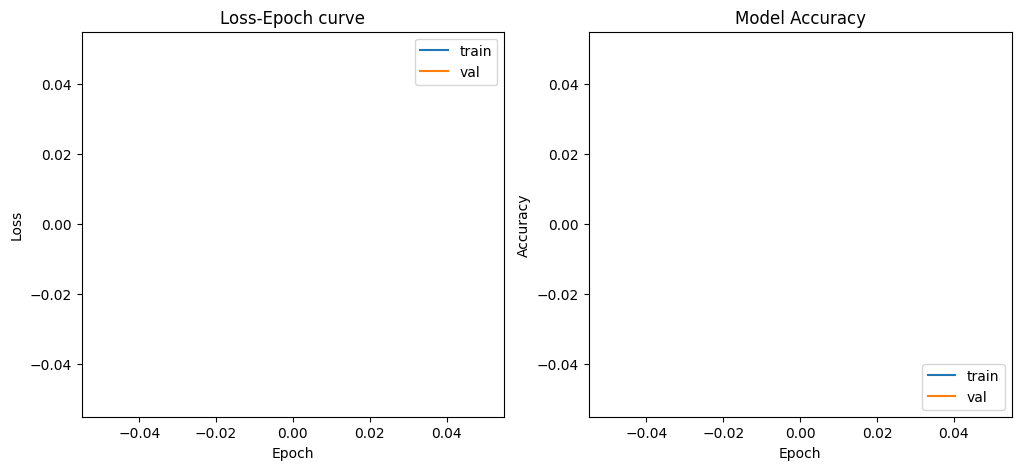

In [29]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

epoch 9 train acc 0.9265392959384504 validation acc 0.8763272200772201


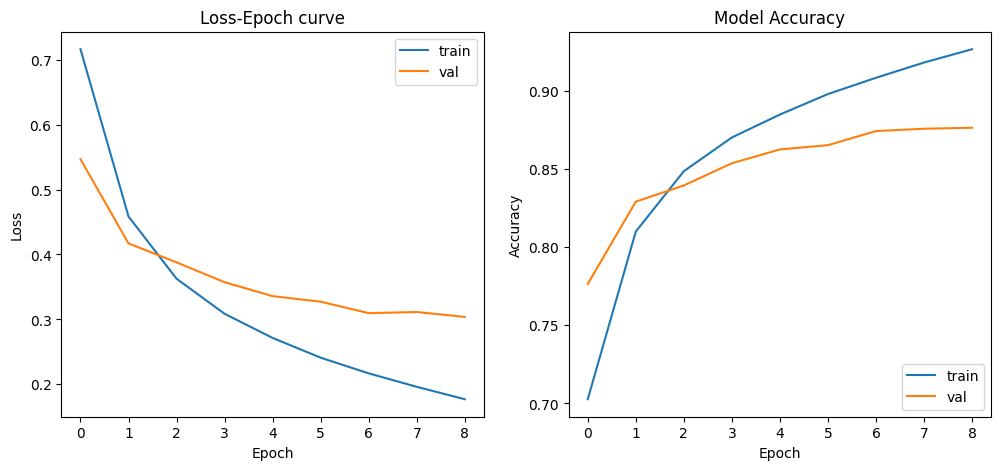

  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 10 train acc 0.933727150056659 loss 0.16056565429937342


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 10 valid acc 0.877361417539989 loss 0.3208100336437213


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 11 train acc 0.9400265402278285 loss 0.14715640912921243


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 11 valid acc 0.8796941073726788 loss 0.325343243154473


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 12 train acc 0.9443931904932307 loss 0.13518730808415372


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 12 valid acc 0.8773097076668506 loss 0.34374468736206704


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 13 train acc 0.9671620594023975 loss 0.07848519192770087


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 13 valid acc 0.8936586458907888 loss 0.3824829414601952


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 14 train acc 0.9742241083676269 loss 0.06153652317092369


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 14 valid acc 0.8922021511307225 loss 0.382274338460145


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 15 train acc 0.9763083735909823 loss 0.05669735992018391


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 15 valid acc 0.8881687810259239 loss 0.41326166217142246


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 16 train acc 0.9839906885548996 loss 0.03681021476845518


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 16 valid acc 0.8938913403199118 loss 0.4604217734839887


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 17 train acc 0.9857519606966064 loss 0.03143894159416526


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 17 valid acc 0.89395166850524 loss 0.48424860515764784


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 18 train acc 0.9867190761615077 loss 0.028471212652694203


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 18 valid acc 0.8937907933443648 loss 0.5203848674586534


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 19 train acc 0.9891203703703704 loss 0.02224368026913871


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 19 valid acc 0.8944457850707851 loss 0.59248549305382


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 20 train acc 0.9899204911433173 loss 0.019877836610065414


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 20 valid acc 0.8951553594410738 loss 0.6512580889551642


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 21 train acc 0.9899236595693923 loss 0.01954748955366425


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 21 valid acc 0.8944429123000552 loss 0.6544157314153827


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 22 train acc 0.9913496376811595 loss 0.01709033377256672


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 22 valid acc 0.8937678111785256 loss 0.7082459040590234


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 23 train acc 0.9915047041808314 loss 0.016032992053392783


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 23 valid acc 0.8953708172458172 loss 0.7281756799823819


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 24 train acc 0.9919063487803423 loss 0.015789513828514797


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 24 valid acc 0.8937390834712263 loss 0.7667092969005824


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 25 train acc 0.9927938808373591 loss 0.014210959160129934


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 25 valid acc 0.8960028268063982 loss 0.758152322992299


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 26 train acc 0.9931552677879166 loss 0.013563554020159732


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 26 valid acc 0.8973386651958081 loss 0.7910377843193998


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 27 train acc 0.9931461352657005 loss 0.013168821797303764


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 27 valid acc 0.8953277256848686 loss 0.7975667139582403


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 28 train acc 0.9941475442834139 loss 0.011931126038978468


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 28 valid acc 0.8954684914506343 loss 0.8228605996602799


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 29 train acc 0.9944243156199678 loss 0.01172923584136271


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 29 valid acc 0.8958505699577128 loss 0.8229611036361721


  0%|          | 0/3105 [00:00<?, ?it/s]

epoch 30 train acc 0.9945098631239936 loss 0.011576594797679718


  0%|          | 0/777 [00:00<?, ?it/s]

epoch 30 valid acc 0.8955403107188822 loss 0.848010191291168


In [30]:
for e in range(epoch_start+1, num_epochs+epoch_start+1):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    classifier.train()
    
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

    for batch_id, batch in enumerate(tqdm.notebook.tqdm(train_loader)):
        optimizer.zero_grad()

        img = batch[0].to(device)
        label = batch[1].to(device) # .squeeze(1) .float()

        out = classifier(img).squeeze(1)
        loss = loss_fn(out, label)

        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        train_acc += calc_accuracy(out, label)

    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    lr = optimizer.param_groups[0]['lr']
    lr_epoch.append(lr)
    print("epoch {} train acc {} loss {}".format(e, tot_train_acc, mean_train_loss))

    classifier.eval()
    with torch.no_grad():
        for batch_id, batch in enumerate(tqdm.notebook.tqdm(valid_loader)):

            img = batch[0].to(device)
            label = batch[1].to(device) # .squeeze(1)

            out = classifier(img).squeeze(1)
            loss = loss_fn(out, label)
            val_loss += loss.item()
            val_acc += calc_accuracy(out, label)
        
    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    lr_scheduler.step(mean_val_loss)
    
    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)
    print("epoch {} valid acc {} loss {}".format(e, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} validation acc {}".format(e, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      best_val_loss = mean_val_loss
      save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                      train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch, lr_epoch,
                      model_path, f'{model_name}_{opt_name}')

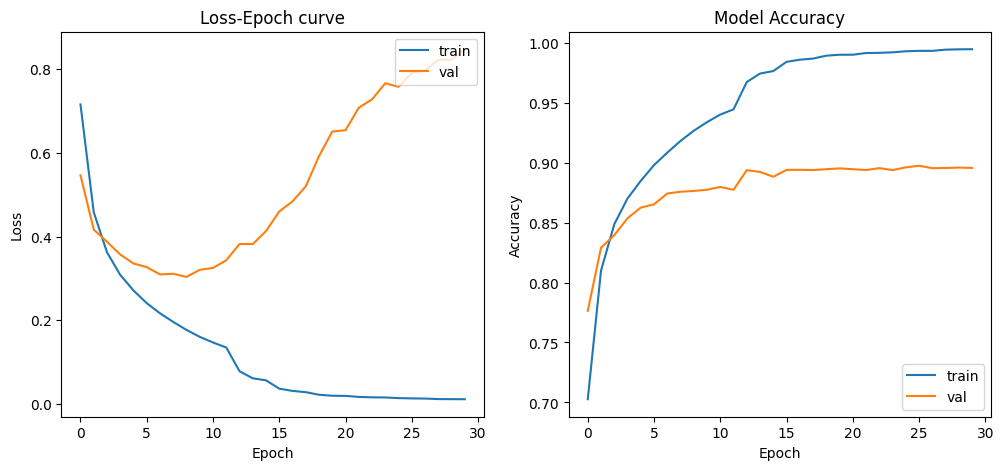

In [31]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

In [32]:
save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch, lr_epoch,
                model_path, f'{model_name}_{opt_name}_{e}epoch')

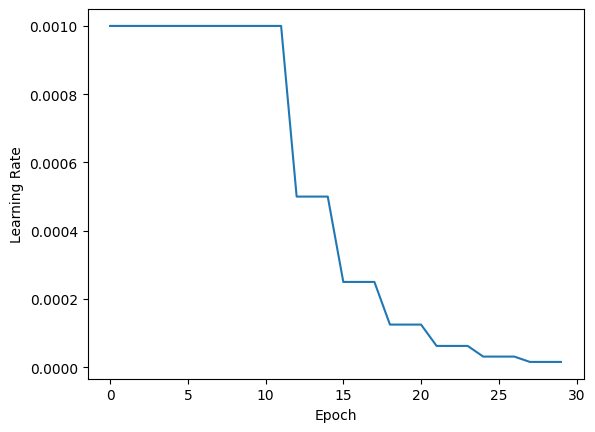

In [33]:
plt.plot(lr_epoch)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# Inference

In [34]:
# file_path = '/kaggle/input/cv-skin-disease/disease/IMG_C_A2_201354.jpg'
# result = inference(file_path)
# print(f'{result[0][0]}일 확률이 {int(result[0][1]*100)}%, {result[1][0]}일 확률이 {int(result[1][1]*100)}% 입니다.')